# Data Preprocessing

## Load dataset
With 80-20 train and validation split

In [1]:
import keras
import numpy as np
import tensorflow as tf
from pathlib import Path
from utils import plot_history
from keras import models, layers
from keras.preprocessing import text_dataset_from_directory
from keras.layers.experimental.preprocessing import TextVectorization

ds_dir = Path('data/C50/')
train_dir = ds_dir / 'train'
test_dir = ds_dir / 'test'
seed = 123
batch_size = 32

train_ds = text_dataset_from_directory(train_dir,
                                       label_mode='categorical',
                                       seed=seed,
                                       shuffle=True,
                                       batch_size=batch_size)

val_ds = text_dataset_from_directory(test_dir,
                                     label_mode='categorical',
                                     seed=seed,
                                     shuffle=True,
                                     batch_size=batch_size,
                                     validation_split=0.2,
                                     subset='validation')

test_ds = text_dataset_from_directory(test_dir,
                                     label_mode='categorical',
                                     seed=seed,
                                     shuffle=True,
                                     validation_split=0.2,
                                     subset='training',
                                     batch_size=128)

Found 2500 files belonging to 50 classes.
Found 2500 files belonging to 50 classes.
Using 500 files for validation.
Found 2500 files belonging to 50 classes.
Using 2000 files for training.


In [2]:
MAX_LEN = 0
for file in train_dir.glob('*/*.txt'):
    with file.open() as f:
        seq_len = 0
        for line in f.readlines():
            seq_len += len(line.split())
#         print(seq_len)
        if MAX_LEN < seq_len:
            MAX_LEN = seq_len
print(f"length of largest article: {MAX_LEN}")

length of largest article: 1460


## Inspect dataset

In [3]:
class_names = train_ds.class_names
class_names = np.asarray(class_names)
print(f"nclasses: {len(class_names)}")
print(f'first 4 classes/users: {class_names[:4]}')
for texts, labels in train_ds.take(1):
    print("Shape of texts", texts.shape)
    print(f'Class of 2nd data point: {class_names[labels.numpy()[1].astype(bool)]}')

nclasses: 50
first 4 classes/users: ['AaronPressman' 'AlanCrosby' 'AlexanderSmith' 'BenjaminKangLim']
Shape of texts (32,)
Class of 2nd data point: ['MureDickie']


In [4]:
for batch, label in iter(val_ds):
    index = np.argmax(label.numpy(), axis=1).astype(np.int)
    print(f'Users of first batch: {class_names[index]}')
    break

Users of first batch: ['BernardHickey' 'MarkBendeich' 'ToddNissen' 'SamuelPerry' 'KeithWeir'
 'BradDorfman' 'TanEeLyn' 'NickLouth' 'GrahamEarnshaw' 'JanLopatka'
 'MarkBendeich' 'KouroshKarimkhany' 'SimonCowell' 'SarahDavison'
 'HeatherScoffield' 'AlexanderSmith' 'RogerFillion' 'ToddNissen'
 'BernardHickey' 'JanLopatka' 'JanLopatka' 'JoWinterbottom' 'ScottHillis'
 'SimonCowell' 'LynnleyBrowning' 'MartinWolk' 'JaneMacartney' 'JoeOrtiz'
 'TanEeLyn' 'SamuelPerry' 'MarkBendeich' 'MartinWolk']


## Text Vectorization
Text vectorization includes the following tasks using `TextVectorization` layer:
1. `Standardization`
2. `Tokenization`
3. `Vectorization`

### Initial run of the vectorization layers
1. Make a text-only dataset (without labels), then call adapt
2. Do not call adapt on test dataset to prevent data-leak
3. train and save vocab to disk

Note: Use it only for the first time or if vocab is not saved

In [5]:
from utils import save_object

### Define vectorization layers
VOCAB_SIZE = 34000
MAX_LEN = 1400

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN
)

# Train the layers to learn a vocab
train_text = train_ds.map(lambda text, lables: text)
vectorize_layer.adapt(train_text)


# Save the vocabulary to disk
# Run this cell for the first time only
vocab = vectorize_layer.get_vocabulary()
vocab_path = Path('vocab/vocab_C50.pkl')
save_object(vocab, vocab_path)
vocab_len = len(vocab)
print(f"vocab size of vectorizer: {vocab_len}")

pickle file vocab_C50.pkl already exists!
object <class 'list'> saved to file vocab_C50.pkl!
vocab size of vectorizer: 34000


### Vectorization layers from saved vocab

In [ ]:
# Load vocab
from utils import load_object
vocab_path = Path('vocab/vocab_C50.pkl')
vocab = load_object(vocab_path)

VOCAB_SIZE = 34000
MAX_LEN  = 1400

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE, 
    output_mode='int',
    output_sequence_length=MAX_LEN,
    vocabulary=vocab
)

In [ ]:
len(vocab)

## Process dataset through layers

In [6]:
def vectorize(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds):
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
train_ds = train_ds.map(vectorize)
val_ds = val_ds.map(vectorize)
test_ds = test_ds.map(vectorize)

# Configure the datasets for fast training 
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [8]:
for text, label in train_ds.take(1):
    print(text.shape)

(32, 1400)


# Modelling and Experimentation

## Base model

In [9]:
##### Pretrained Glove Embeddings #####
## Parse the weights
from utils import load_object
emb_dim = 100
glove_file = Path(f'vocab/glove/glove.6B.{emb_dim}d.txt')
emb_index = {}
with glove_file.open(encoding='utf-8') as f:
    for line in f.readlines():
        values = line.split()
        word = values[0]
        coef = values[1:]
        emb_index[word] = coef

##### Getting embedding weights #####
vocab = load_object(Path('vocab/vocab_C50.pkl'))
emb_matrix = np.zeros((VOCAB_SIZE, emb_dim))
for index, word in enumerate(vocab):
    # get coef of word
    emb_vector = emb_index.get(word)
    if emb_vector is not None:
        emb_matrix[index] = emb_vector
print(emb_matrix.shape)

loaded object from file vocab_C50.pkl
(34000, 100)


In [16]:
keras.backend.clear_session()
lstm_model = models.Sequential([
    layers.Embedding(VOCAB_SIZE, emb_dim, input_shape=(MAX_LEN,)),
    layers.Conv1D(256, 11, activation='relu'),
    layers.MaxPooling1D(7),
    layers.Dropout(0.4),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(3),
    layers.Dropout(0.2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(50, activation='softmax')
])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1400, 100)         3400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 1390, 256)         281856    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 198, 256)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 198, 256)          394240    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          98432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 65, 128)           0

In [17]:
lstm_model.layers[0].set_weights([emb_matrix])
lstm_model.layers[0].trainable = False
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1400, 100)         3400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 1390, 256)         281856    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 198, 256)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 198, 256)          394240    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          98432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 65, 128)           0

Epoch 1/50
79/79 [==============================] - 12s 151ms/step - loss: 0.0892 - acc: 0.9704 - val_loss: 3.6581 - val_acc: 0.4920
Epoch 2/50
79/79 [==============================] - 12s 147ms/step - loss: 0.0817 - acc: 0.9768 - val_loss: 3.4798 - val_acc: 0.4680
Epoch 3/50
79/79 [==============================] - 11s 144ms/step - loss: 0.0736 - acc: 0.9732 - val_loss: 3.4315 - val_acc: 0.5200
Epoch 4/50
79/79 [==============================] - 11s 145ms/step - loss: 0.0891 - acc: 0.9716 - val_loss: 3.5485 - val_acc: 0.5000
Epoch 5/50
79/79 [==============================] - 11s 143ms/step - loss: 0.0636 - acc: 0.9816 - val_loss: 3.7681 - val_acc: 0.4820
Epoch 6/50
79/79 [==============================] - 11s 145ms/step - loss: 0.1027 - acc: 0.9696 - val_loss: 3.4984 - val_acc: 0.4920
Epoch 7/50
79/79 [==============================] - 11s 145ms/step - loss: 0.0725 - acc: 0.9768 - val_loss: 3.4113 - val_acc: 0.5100
Epoch 8/50
79/79 [==============================] - 11s 143ms/step - 

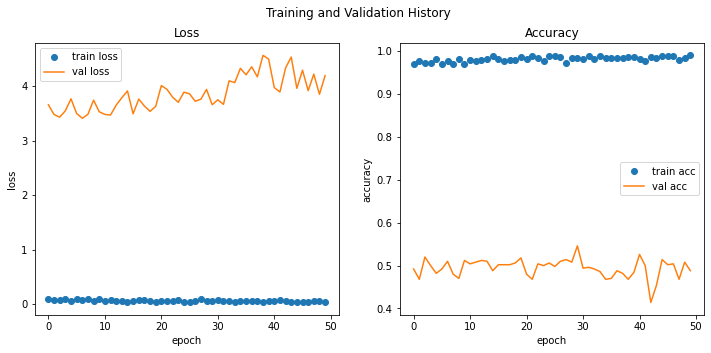

In [20]:
# from keras.optimizers import RMSprop

# optim = RMSprop(lr=1e-4)

# lstm_model.compile(
#     loss='CategoricalCrossentropy',
#     optimizer=optim,
#     metrics=['acc']
# )
lstm_history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


plot_history(lstm_history)

In [21]:
lstm_model.evaluate(test_ds)

16/16 [==============================] - 36s 1s/step - loss: 3.8160 - acc: 0.5180


[3.8159797191619873, 0.5180000066757202]